[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vidya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vidya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vidya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vidya\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'day_diff',
       'helpful_yes', 'total_vote'],
      dtype='object')


c:\Users\vidya\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


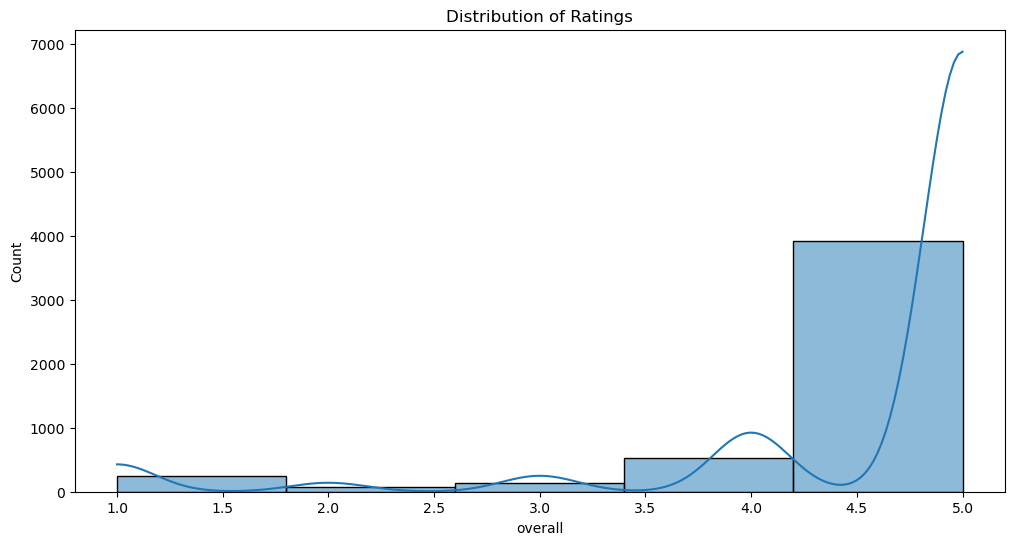

Logistic Regression Accuracy: 0.9257375381485249
Logistic Regression Precision: 0.9005099712310581
Logistic Regression Recall: 0.9257375381485249
Logistic Regression F1 Score: 0.9033232187840013
Naive Bayes Accuracy: 0.9033570701932858
Naive Bayes Precision: 0.8160539962681971
Naive Bayes Recall: 0.9033570701932858
Naive Bayes F1 Score: 0.8574891270247331
Epoch 1/5
62/62 [==============================] - 20s 269ms/step - loss: 0.4737 - accuracy: 0.9056 - val_loss: 0.3542 - val_accuracy: 0.9034
Epoch 2/5
62/62 [==============================] - 15s 244ms/step - loss: 0.2905 - accuracy: 0.9069 - val_loss: 0.2345 - val_accuracy: 0.9257
Epoch 3/5
62/62 [==============================] - 15s 242ms/step - loss: 0.1879 - accuracy: 0.9425 - val_loss: 0.2186 - val_accuracy: 0.9237
Epoch 4/5
62/62 [==============================] - 15s 239ms/step - loss: 0.1448 - accuracy: 0.9540 - val_loss: 0.2325 - val_accuracy: 0.9257
Epoch 5/5
31/31 [==============================] - 2s 32ms/step
LSTM Accur

c:\Users\vidya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vidya\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


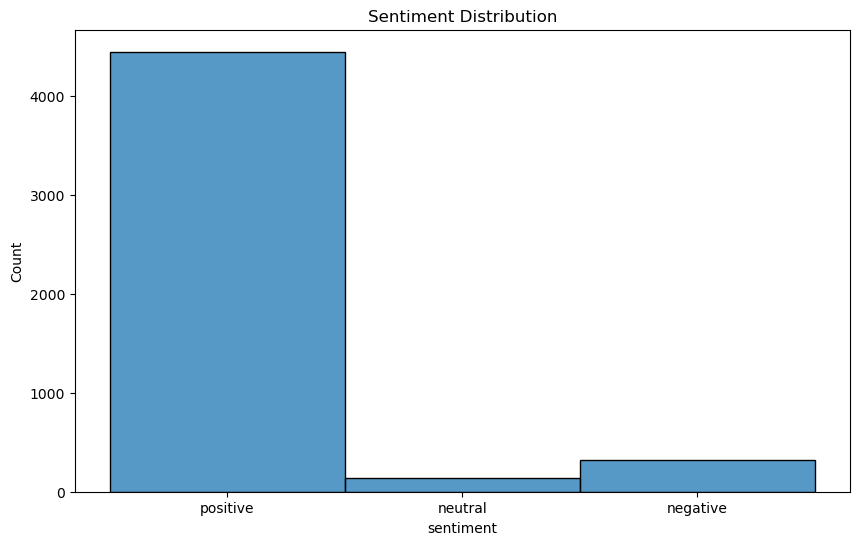

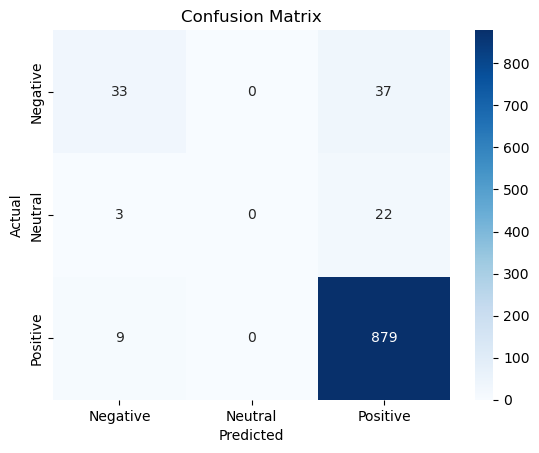

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json

# Download the required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load the dataset
df = pd.read_csv('..\\data\\raw\\amazon_review.csv')

# Inspect the columns to find the correct one
print(df.columns)

# Assuming the correct column name is identified, let's say they are 'reviewText' and 'overall'
review_column_name = 'reviewText'  # Change this to the actual column name for reviews
rating_column_name = 'overall'     # Change this to the actual column name for ratings

# Data Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text)  # Convert to string
    words = word_tokenize(text.lower())
    words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)

df['cleaned_review'] = df[review_column_name].apply(preprocess_text)

# Exploratory Data Analysis
df['word_count'] = df['cleaned_review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(df[rating_column_name], bins=5, kde=True)
plt.title('Distribution of Ratings')
plt.show()

# Sentiment Analysis (Labeling Sentiments)
def label_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df[rating_column_name].apply(label_sentiment)

# Prepare data for LSTM model
max_length = 200
vocab_size = 5000
embedding_dim = 128

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

X = padded_sequences
y = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2}).values

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Models (Using TF-IDF Vectorization)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['cleaned_review']).toarray()
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB()
}

for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train_tfidf)
    y_pred = model.predict(X_test_tfidf)
    print(f'{model_name} Accuracy: {accuracy_score(y_test_tfidf, y_pred)}')
    print(f'{model_name} Precision: {precision_score(y_test_tfidf, y_pred, average="weighted", zero_division=0)}')
    print(f'{model_name} Recall: {recall_score(y_test_tfidf, y_pred, average="weighted")}')
    print(f'{model_name} F1 Score: {f1_score(y_test_tfidf, y_pred, average="weighted")}')

# Advanced Models - LSTM
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=64)

# Model Evaluation
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print('LSTM Accuracy:', accuracy_score(y_test, y_pred))
print('LSTM Precision:', precision_score(y_test, y_pred, average='weighted'))
print('LSTM Recall:', recall_score(y_test, y_pred, average='weighted'))
print('LSTM F1 Score:', f1_score(y_test, y_pred, average='weighted'))

# Visualization
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], kde=False)
plt.title('Sentiment Distribution')
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
